In [10]:
%pylab inline
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader

from torchvision import transforms
from torchvision.datasets import MNIST

from graphviz import Digraph

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Configuration

In [4]:
BATCH_SIZE = 32

## Data (MNIST)

In [5]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
    
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE ,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

## Model Discriminator

### Discriminator

* $ x_i \sim P_{\rm data} $ (즉 true data distribution) 에서 왔다면 1
* $ x_i = G(z) $ 이때 $ z \sim p_{\rm generator} $ (generators' distribution)에서 왔다면 0

즉 Discriminator는 "이 사진이 진짜냐? (가짜가 아니고)" 라고 질문하는 것

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(784, 548)
        self.fc2 = nn.Linear(548, 252)
        self.fc3 = nn.Linear(252, 1)
        
        self.bc1 = nn.BatchNorm1d(548)
        self.bc2 = nn.BatchNorm1d(252)
                
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        out = F.sigmoid(h)
        return out

D = Discriminator()
print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

Discriminator (
  (fc1): Linear (784 -> 548)
  (fc2): Linear (548 -> 252)
  (fc3): Linear (252 -> 1)
  (bc1): BatchNorm1d(548, eps=1e-05, momentum=0.1, affine=True)
  (bc2): BatchNorm1d(252, eps=1e-05, momentum=0.1, affine=True)
)


### Generator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(100, 196)
        self.fc2 = nn.Linear(196, 289)
        self.fc3 = nn.Linear(289, 361)
        self.fc4 = nn.Linear(361, 529)
        self.fc5 = nn.Linear(529, 784)
        
        self.bc1 = nn.BatchNorm1d(196)
        self.bc2 = nn.BatchNorm1d(289)
        self.bc3 = nn.BatchNorm1d(361)
        self.bc4 = nn.BatchNorm1d(529)
    
    def forward(self, x):
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.3, training=self.training)
        
        h = self.fc3(h)
        h = self.bc3(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc4(h)
        h = self.bc4(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc5(h)
        out = F.sigmoid(h)
        return out

G = Generator()
print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.001)

Generator (
  (fc1): Linear (100 -> 196)
  (fc2): Linear (196 -> 289)
  (fc3): Linear (289 -> 361)
  (fc4): Linear (361 -> 529)
  (fc5): Linear (529 -> 784)
  (bc1): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True)
  (bc2): BatchNorm1d(289, eps=1e-05, momentum=0.1, affine=True)
  (bc3): BatchNorm1d(361, eps=1e-05, momentum=0.1, affine=True)
  (bc4): BatchNorm1d(529, eps=1e-05, momentum=0.1, affine=True)
)


## Visualization

In [8]:
def make_dot(var):
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def add_nodes(var):
        if var not in seen:
            if isinstance(var, Variable):
                value = '('+(', ').join(['%d'% v for v in var.size()])+')'
                dot.node(str(id(var)), str(value), fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'previous_functions'):
                for u in var.previous_functions:
                    dot.edge(str(id(u[0])), str(id(var)))
                    add_nodes(u[0])
    add_nodes(var.creator)
    return dot

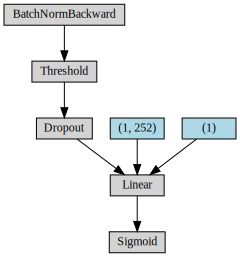

In [40]:
real_image = train[0][0].cuda()
real_image = Variable(real_image)
make_dot(D(real_image))

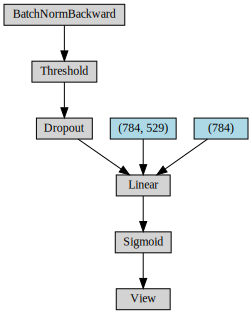

In [11]:
fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
images = G(fake_distributions).view((-1, 28, 28))
make_dot(images)

## Train

* $ 1 $ : real images
* $ 0 $ : fake images

In [6]:
N_EPOCH = 100

real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = list()
d_fake_losses = list()
g_losses = list()

In [11]:
# Train Discriminator with Generator not being trained
# 먼저 Discriminator를 학습시킵니다.
# 이때 real image와 fake이미지 두개의 데이터를 사용하여 학습합니다. 
# Discriminator를 학습시킬때는 Generator는 학습시키면 안됩니다.

for epoch in range(N_EPOCH):
    _d_real_losses = list()
    _d_fake_losses = list()
    _g_losses = list()
    
    
    for step, (real_images, _) in enumerate(train_loader):
        real_images = Variable(real_images.cuda())

        # Init D
        d_optimizer.zero_grad()

        ###############################################
        # Train D with real images
        ###############################################
        y_real_pred = D(real_images)
        d_real_loss = loss_f(y_real_pred, real_y)
        d_real_loss.backward()
        d_optimizer.step()
        
        # Visualization
        _d_real_losses.append(d_real_loss.data[0])

        ###############################################
        # Train D with fake images but do not train G
        ###############################################
        fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        fake_images = G(fake_distributions).detach()
        y_pred = D(fake_images)
        d_fake_loss = loss_f(y_pred, fake_y)
        d_fake_loss.backward()
        d_optimizer.step()
        
        # Visualization
        _d_fake_losses.append(d_fake_loss.data[0])

        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        fake_images = G(fake_distributions)
        y_pred = D(fake_images)
        g_loss = loss_f(y_pred, real_y)
        g_loss.backward()
        g_optimizer.step()
        
        # Visualization
        _g_losses.append(g_loss.data.cpu().numpy()[0])
        
        if step % 200 == 0:
            _d_real_losses = np.array(_d_real_losses)
            _d_fake_losses = np.array(_d_fake_losses)
            _g_losses = np.array(_g_losses)
            
            d_real_losses.append(_d_real_losses.mean())
            d_fake_losses.append(_d_fake_losses.mean())
            g_losses.append(_g_losses.mean())
            
            _d_real_losses = list()
            _d_fake_losses = list()
            _g_losses = list()
            
            print(f'\rEpoch:[{epoch}] Step:[{step}] -',
                  '[D_real_loss]: {:.4}'.format(d_real_loss.data[0]),
                  '[D_fake_loss]: {:.4}'.format(d_fake_loss.data[0]), 
                  '[G_loss]:{:.4}'.format(g_loss.data[0]), end='') 
    print()

Epoch:[0] Step:[1800] - [D_real_loss]: 0.04605 [D_fake_loss]: 0.5393 [G_loss]:2.4467
Epoch:[1] Step:[1800] - [D_real_loss]: 0.3806 [D_fake_loss]: 1.408 [G_loss]:3.07887
Epoch:[2] Step:[1800] - [D_real_loss]: 0.08285 [D_fake_loss]: 0.2951 [G_loss]:3.4116
Epoch:[3] Step:[1800] - [D_real_loss]: 0.06229 [D_fake_loss]: 0.09555 [G_loss]:1.614
Epoch:[4] Step:[1800] - [D_real_loss]: 0.008691 [D_fake_loss]: 0.9724 [G_loss]:1.348
Epoch:[5] Step:[1800] - [D_real_loss]: 0.01324 [D_fake_loss]: 0.2641 [G_loss]:2.6956
Epoch:[6] Step:[1800] - [D_real_loss]: 0.2643 [D_fake_loss]: 0.2674 [G_loss]:2.07247
Epoch:[7] Step:[1800] - [D_real_loss]: 0.0411 [D_fake_loss]: 0.1873 [G_loss]:2.7012
Epoch:[8] Step:[1800] - [D_real_loss]: 0.0468 [D_fake_loss]: 0.4728 [G_loss]:0.43943
Epoch:[9] Step:[1800] - [D_real_loss]: 0.01478 [D_fake_loss]: 0.7266 [G_loss]:2.7876
Epoch:[10] Step:[1800] - [D_real_loss]: 1.895 [D_fake_loss]: 0.8621 [G_loss]:1.5222
Epoch:[11] Step:[1800] - [D_real_loss]: 0.2718 [D_fake_loss]: 1.069 

## Loss Visualization

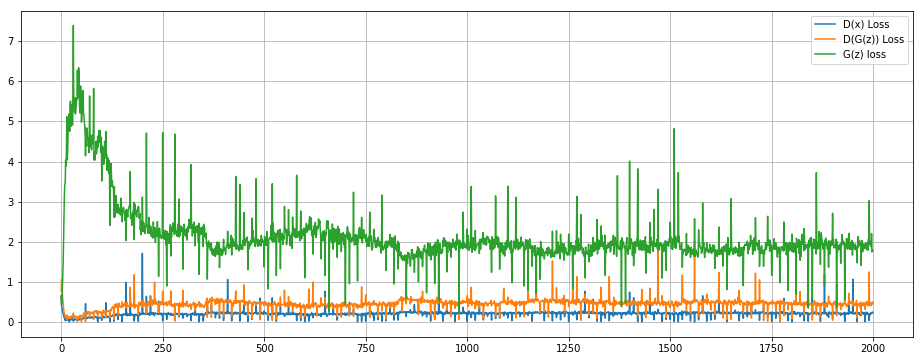

In [12]:
plot(d_real_losses, label='D(x) Loss')
plot(d_fake_losses, label='D(G(z)) Loss')
plot(g_losses, label='G(z) loss')

grid()
legend()
figsize(16, 6)

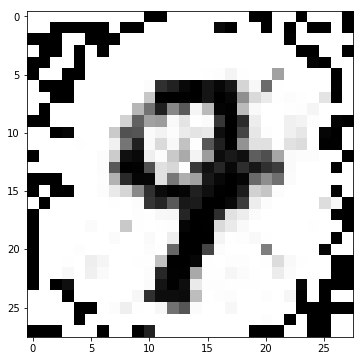

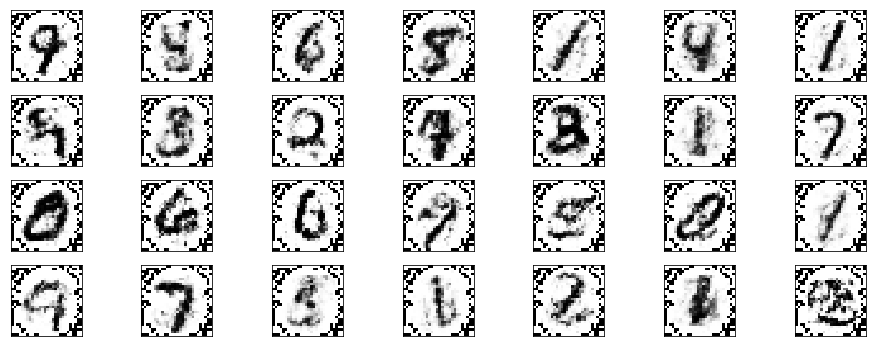

In [26]:
fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
images = G(fake_distributions).view((-1, 28, 28)).data.cpu().numpy()

images[0]
imshow(images[0], cmap=cm.gray_r)

fig, subplots = pylab.subplots(4, 7) # subplots(y축, x축 갯수)

idx = 0
for _subs in subplots:
    for subplot in _subs:
        d = images[idx]
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(d, cmap=cm.gray_r)
        idx += 1
